
### Which not-for-profits might be at the highest risk for fraud?
1.  Small number of staff members compared to the volume of money raised
    - employee count / current year revenue
    - fewer employees can translate to weaker controls over ...
1. Employees as a percentage of over 100K contractors
    - employee count / count of contractors over 100K
    - fewer employees can translate to weaker controls over vetting and payment of contractors
1.  Small number of voting members and independent voting members compared to revenue
    - this could be indicative of low oversight of the organization
    - dataset also includes independent vs. non-independent voting members, unsure about specific differences
1. Salaries expense as a percentage of revenue
    - not-for-profit management could be paying themselves a disproportionate salary


### Data source:
https://www.open990.org/catalog/, this company provides raw data for free, however they also provide analytics services for a charge https://appliednonprofitresearch.com/customdata/

overview of data provided by open990
https://medium.com/@open990/the-irs-990-e-file-dataset-getting-to-the-chocolatey-center-of-data-deliciousness-90f66097a600

This dataset has great documentation about what the attributes mean, however this only includes data for 1 year(2016).

### Not-for-profit info to inform my process
https://en.wikipedia.org/wiki/501(c)_organization - there are many different types of 501(c) orgs, each type is organized around a specific category of activity, labor, social and recreational, business leagues, ect.

__501(c)(3) categories of activity__ - Religious, Educational, Charitable, Scientific, Literary, Testing for Public Safety, to Foster National or International Amateur Sports Competition, or Prevention of Cruelty to Children or Animals Organizations

https://nonprofitrisk.org/resources/articles/a-violation-of-trust-fraud-risk-in-nonprofit-organizations/

One area in which nonprofit organizations seem particularly vulnerable is billing schemes, in which an employee fraudulently submits invoices to obtain payments he or she is not entitled to receive. According to the most recent ACFE survey, billing schemes were among the most common fraud methods in the cases studied for the 2012 report.

Billing schemes often involve the creation of a shell company. In such a fraud, a dishonest employee sets up a fake identity that bills for good or services the organization does not receive. In some instances, goods or services may be delivered but are marked up excessively, with the proceeds diverted to the employee.


In [121]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore

In [4]:
df = pd.read_csv('data/Open990_Contractor_Compensation_Snack_Set_Public_2019-01-24.csv',
                 encoding = 'unicode_escape',
                 engine='python')

### Pre-Processing Steps
1. limit data to only orgs with contractor payments in excess of 100K
1. refine categories of non-profit mission/purpose statements
    - completing this task in *990_mission_statement* notebook.
1. refine categories of services being provided to the orgs
    - there is probably a high level of inconsistency here
    - this will require a summarization process similar to what I'm doing for the mission statement of the orgs
1. convert NaN values into False
    - for many boolean fields in the 990, the absense of a response is interpreted as NaN, converting these to False will allow for a machine readable format. 
1. format target variable for machine learning algorithems to make predictions on
    - somewhere around 10% of the dataset
1. 


In [38]:
# how large is the full dataset?
df.shape

(237448, 110)

In [39]:
# examine columns in full dataset
df.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string
0,10018927,AMERICAN LEGION POST 5 BOURQUE-LANIGAN,2016-01-01,2016-12-31,2016,AMERICAN LEGION POST 5,+1 (207) 872-8824,WTVLLEGION.ORG,21 COLLEGE AVENUE,WATERVILLE,ME,NaN,04901,True,NaN,NaN,NaN,NaN,1926.0,925.0,ME,no,NaN,NaN,True,19.0,501808,NaN,9,9,8,0.0,0,0.0,11458.0,0.0,983.0,137239.0,149680.0,0.0,20120.0,61034.0,0.0,0,113034.0,194188.0,-44508.0,595704.0,29618.0,566086.0,12549,0,1036,128465,142050,0,22141,62171,0,100057,184369,-42319,561928,38161,523767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,010018927_201612,2016v3.0,201721359349307007,NzM0MjczMTQ5MzAyOTkxNjA2NQ
1,10018930,AMERICAN LEGION - MAINE DEPARTMENT,2015-05-01,2016-04-30,2016,NaN,+1 (207) 873-3229,WWW.MAINELEGION.ORG,PO BOX 900,WINSLOW,ME,NaN,049010727,True,NaN,NaN,NaN,NaN,1919.0,NaN,ME,no,NaN,NaN,True,19.0,784286,NaN,60,56,10,NaN,0,NaN,488958.0,214498.0,2452.0,62279.0,768187.0,3500.0,NaN,263411.0,NaN,0,518288.0,785199.0,-17012.0,941168.0,364115.0,577053.0,487889,210898,1613,83886,784286,4500,0,245792,0,482665,732957,51329,995802,367420,628382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,010018930_201604,2015v2.1,201622149349301207,NjA2ODIzMDg0NzYyMzA2MDM2NA
2,10019705,Ancient Free and Accepted Masons of Maine Gran...,2015-04-01,2016-03-31,2016,NaN,+1 (207) 358-3110,www.mainemason.org,P O Box 430,Holden,ME,NaN,044290430,True,NaN,NaN,NaN,NaN,1820.0,275.0,ME,no,NaN,NaN,True,10.0,362909,NaN,11,9,5,0.0,0,0.0,1837.0,321565.0,29073.0,1972.0,354447.0,0.0,0.0,78522.0,0.0,0,236707.0,315229.0,39218.0,1704310.0,0.0,1704310.0,1402,315455,29298,-13191,332964,18061,0,86383,0,241884,346328,-13364,1640608,0,1640608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [36]:
# find count of null values
# for each column
(df.isna().sum()/df.isna().count()) * 100

ein                                      0.000000
name_org                                 0.000000
tax_date_begin                           0.000000
tax_date_end                             0.000000
tax_yr                                   0.000000
doing_business_as                       94.005424
phone                                   10.273407
website                                 34.804673
address                                  0.000421
city                                     0.002106
state                                    0.030322
country                                 99.917877
zip                                      0.010529
org_form.corp                           11.653499
org_form.trust                          96.870473
org_form.association                    95.570820
org_form.other_form                     97.630218
org_form.other_form_desc                98.252670
formation_yr                             7.177572
grp_exempt_num                          96.654847


In [5]:
# what is the date range
df.tax_date_begin.min()

'2014-12-27'

In [6]:
df.tax_date_begin.max()

'2016-12-28'

### Limit dataset to only orgs with payments to contractors over 100K

In [42]:
# identify columns with salary in them
for c in df.columns:
    if '100' in c:
        print(c)       

contractor_100k_ct


In [53]:
# subset data based on orgs with contractor payments over 100K
df_con = df[~df.name_contractor_1.isnull()]

In [54]:
# examine size of data
df_con.shape

(30589, 110)

In [249]:
df_con.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string,con_ct_div_emp_ct
13,10056837,EASTERN MAINE ELECTRIC COOPERATIVE INC,2016-01-01,2016-12-31,2016,NaN,+1 (207) 454-7555,www.emec.com,PO Box 425,Calais,ME,NaN,046190425,True,NaN,NaN,NaN,NaN,1940.0,NaN,ME,no,NaN,NaN,True,12.0,15549792,NaN,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP,PO Box 9546,Portland,ME,04112,NaN,Legal,284923.0,On Target Utility Services,617 Water St,Gardiner,ME,04345,NaN,Utility Construction,526681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010056837_201612,2016v3.0,201722499349300607,NTk1ODY4MDk3ODk3NjYyMDY2OQ,0.050847
17,10079380,CPORT CREDIT UNION,2016-01-01,2016-12-31,2016,NaN,+1 (207) 878-6200,WWW.CPORTCU.ORG,PO BOX 777,PORTLAND,ME,NaN,04104,True,NaN,NaN,NaN,NaN,1931.0,NaN,ME,no,NaN,NaN,True,14.0,9472036,NaN,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING,120 EXCHANGE STREET,PORTLAND,ME,04101,NaN,INFORMATION TECH. SERVICES,171160.0,PM SYSTEMS (ACI WORLDWIDE CORP),99944 COLLECTION CENTER DR,CHICAGO,IL,60693,NaN,ONLINE BANKING PROVIDER,147655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010079380_201612,2016v3.0,201713179349301261,NTAxNDUzNjQ4MzgwNDIzMTg2MA,0.028302
27,10114035,Maine Education Association,2015-09-01,2016-08-31,2016,NaN,+1 (207) 622-5866,www.maine.nea.org,35 Community Drive

###  General Visualization

In [ ]:
# show histogram for each outlier column
# to show the distribution of the data

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp.columns[3:]):
    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.scatter(life_exp['life_expectancy_'], life_exp[column], color='brown', alpha=.03);

In [243]:
df_con.contractor_100k_ct.head()

13    3.0
17    3.0
27    3.0
37    8.0
45    1.0
Name: contractor_100k_ct, dtype: float64

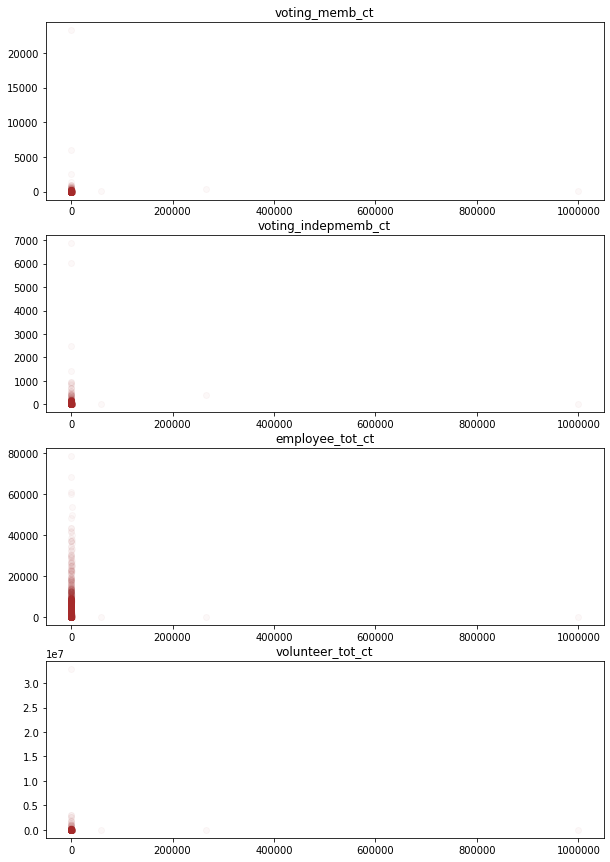

In [246]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    plt.scatter(df_con.contractor_100k_ct, df_con[column], color='brown', alpha=.03);


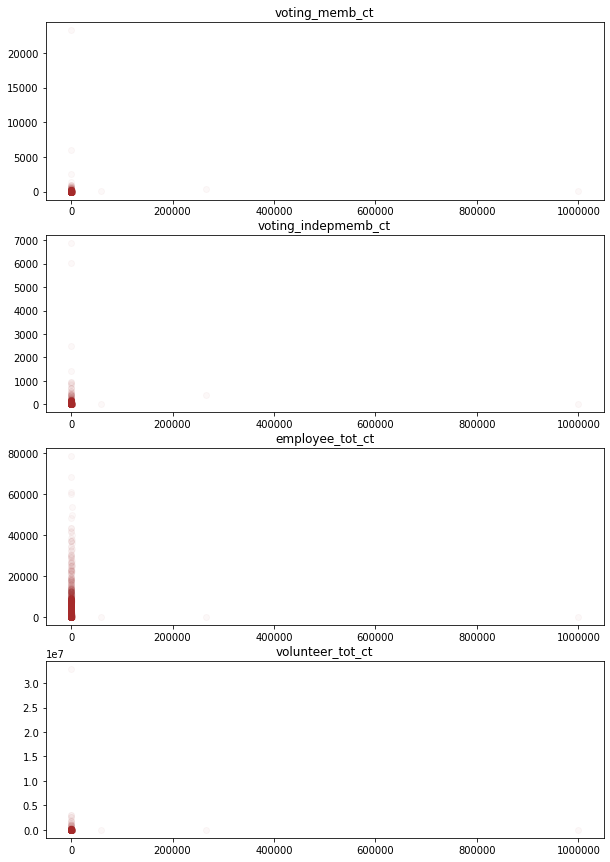

In [246]:
# graph employees against revenue
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    plt.scatter(df_con.contractor_100k_ct, df_con[column], color='brown', alpha=.03);


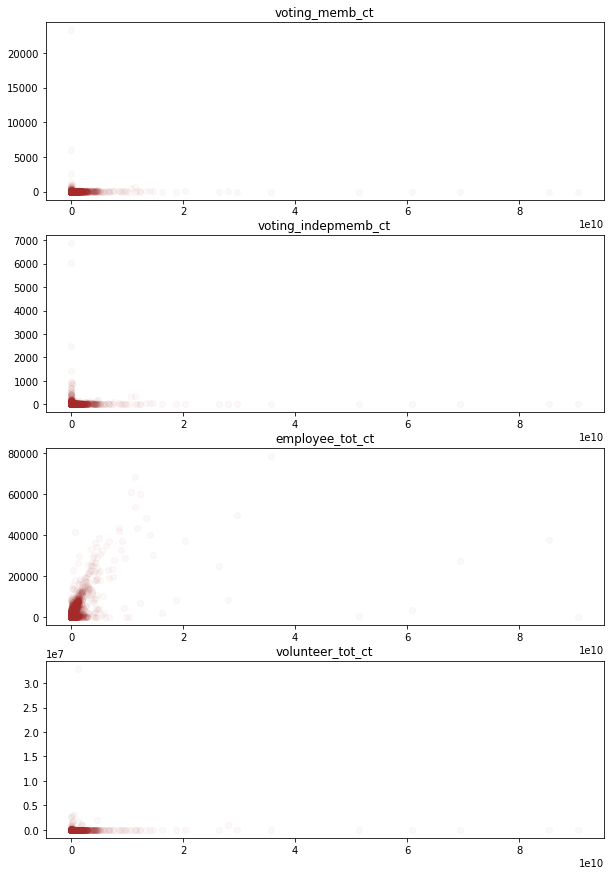

In [254]:
# graph employees against gross receipts
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    plt.scatter(df_con.gross_receipts, df_con[column], color='brown', alpha=.03);


In [251]:
# fill na for financial data
# fill nans with 0 so that I can perform math on these amounts

for column in list(df_con.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns):
    df_con[column].fillna(0, inplace=True)

In [252]:
for column in list(df_con.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns):
    print(df_con[column].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


###  Employees, volunteers, and voting members as a percentage of over 100K contractors

In [63]:
# df_con.employee_tot_ct.value_counts()

In [81]:
# identify columns with employee in them
for c in df.columns:
    if 'vol' in c:
        print(c)       

volunteer_tot_ct


In [141]:
# identify columns with employee in them
for c in df.columns:
    if 'contractor' in c:
        print(c)       

name_contractor_1
address_contractor_1
city_contractor_1
state_contractor_1
zip_contractor_1
country_contractor_1
services_contractor_1
amt_paid_contractor_1
name_contractor_2
address_contractor_2
city_contractor_2
state_contractor_2
zip_contractor_2
country_contractor_2
services_contractor_2
amt_paid_contractor_2
name_contractor_3
address_contractor_3
city_contractor_3
state_contractor_3
zip_contractor_3
country_contractor_3
services_contractor_3
amt_paid_contractor_3
name_contractor_4
address_contractor_4
city_contractor_4
state_contractor_4
zip_contractor_4
country_contractor_4
services_contractor_4
amt_paid_contractor_4
name_contractor_5
address_contractor_5
city_contractor_5
state_contractor_5
zip_contractor_5
country_contractor_5
services_contractor_5
amt_paid_contractor_5
contractor_100k_ct


In [150]:
# identify columns with count of vendors
for c in df.columns:
    if '100k_ct' in c:
        print(c)       

contractor_100k_ct


In [169]:
# a number of orgs show non-null values in name_contractor_1
# however either NaN or null in contractor_100k_ct
# this should not be possible 
# in these cases fill in 1 in the contractor_100k_ct

pd.options.mode.chained_assignment = None

df_con.loc[df_con['contractor_100k_ct'].isnull(), 'contractor_100k_ct'] = 1
df_con.loc[df_con['contractor_100k_ct'] == 0, 'contractor_100k_ct'] = 1

In [170]:
# why are there still so many nulls here?
df_con[df_con['con_ct_div_emp_ct'].isnull()].shape

(3150, 111)

In [188]:
# for voting_memb_ct, voting_indepmemb_ct, employee_tot_ct, volunteer_tot_ct
# fill nans with 0 so that I can perform math on these amounts

for column in list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns):
    df_con[column].fillna(0, inplace=True)

In [189]:
# verify nulls have been filled properly
for column in list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns):
    print(df_con[column].isnull().sum())

0
0
0
0


In [196]:
# verify data type
for column in list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns):
    print(df_con[column].dtype)

int64
int64
int64
float64


In [198]:
df_con['contractor_100k_ct'].dtype

dtype('float64')

In [199]:
# SettingWithCopyWarning
# I see no reason why it should be raised in this situation
pd.options.mode.chained_assignment = None

df_con['con_ct_div_emp_ct'] = df_con['contractor_100k_ct'] / (df_con['employee_tot_ct'] + df.voting_memb_ct + df.voting_indepmemb_ct + df.volunteer_tot_ct)

In [200]:
# how many orgs had zero employees, independent members, and volunteers?
# this will create 'inf'
# it's not clear to me why orgs will have none of these
# they seem to be outliers, I will drop them for now

df_con[df_con['con_ct_div_emp_ct'] == np.inf].shape

(0, 111)

In [201]:
# drop exception orgs
df_con.drop(df_con[df_con['con_ct_div_emp_ct'] == np.inf].index, inplace=True)

In [202]:
# verify they have been removed

df_con[df_con['con_ct_div_emp_ct'] == np.inf].shape

(0, 111)

In [204]:
# why am I still ending up with 3000 + null values
df_con[df_con['con_ct_div_emp_ct'].isnull()].shape

(3150, 111)

In [207]:
# for now I'm just going to drop them
df_con.drop(df_con[df_con['con_ct_div_emp_ct'].isnull()].index, inplace=True)

In [209]:
df_con['con_ct_div_emp_ct'].max()

3058.1009174311926

In [210]:
df_con['con_ct_div_emp_ct'].min()

7.904963368399751e-07

In [216]:
# how many orgs remain?
df_con['con_ct_div_emp_ct'].shape

(27408,)

#### trying to identify a percentage of orgs above a threshold, what is the best way for me to do this?

In [226]:
z_scores = zscore(df_con['con_ct_div_emp_ct'])

# iterate through threshold levels
# comparing the value of each z score
# against the value of the threshold

# for threshold == 5:
#     print("The score threshold is: {}".format(threshold))
#     print("The indices of the outliers:")
#     print(np.where(z_scores > threshold))
len((np.where(z_scores > 2)[0]))

10

This doesn't seem right to me.

In [212]:
z_scores[0:10]

array([-0.01152335, -0.0125172 , -0.01331344, -0.01301764, -0.01355783,
       -0.01361137, -0.01361714, -0.0125734 , -0.01210133, -0.01341494])

In [213]:
# find the 95th quartile
q95 = np.percentile(df_con['con_ct_div_emp_ct'], [95])

In [230]:
q95

array([0.22222222])

In [233]:
# find everything above the 95th quartile
np.where(z_scores > q95)

(array([ 1201,  1384,  2102,  2186,  2273,  3208,  3214,  3344,  4292,
         4390,  8447,  9208,  9394,  9482,  9657,  9740, 11386, 12445,
        13119, 13455, 13638, 13691, 14537, 15817, 16284, 16807, 17983,
        19450, 22535, 22898, 22979, 22986, 23884, 26149, 27367],
       dtype=int64),)

but how do I feed this into my data frame?

In [235]:
# which orgs are three standard deviations from the mean?
# I want to flag the highest numbers since they are 
# indicative of fewer employees handling larger number of contractors
df_con['con_ct_div_emp_ct'].sort_values(ascending=False).head(20)

79651     3058.100917
9578      2095.321429
20554      364.857143
84304      323.227494
197434     219.000000
81350      194.857143
15413      164.428571
21348       61.500000
82385       51.125000
14632       46.600000
105675      37.774194
84923       26.555556
209166      15.000000
30192       14.272727
28873       14.000000
228645      13.000000
194343      12.000000
111020      11.384615
164402      10.611111
16284       10.000000
Name: con_ct_div_emp_ct, dtype: float64

#### Visualizations

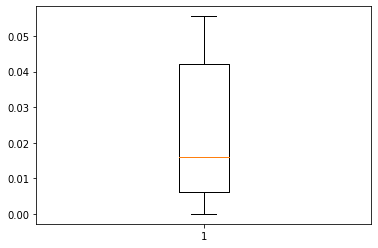

In [239]:
# had to remove outliers just to get it to plot
# otherwise I get an error message
plt.boxplot(winsorize(df_con['con_ct_div_emp_ct'], (0,.2)));

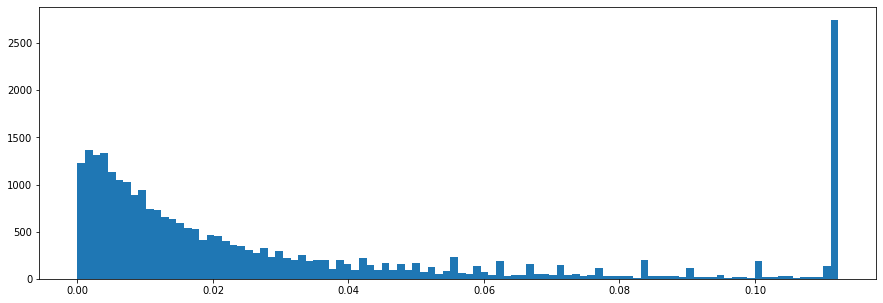

In [241]:
# again I had to winsorize just to avoid error messages
plt.subplots(figsize=(15, 5))

# distribution
plt.hist(winsorize(df_con['con_ct_div_emp_ct'], (0,.1)), bins=100);

### Salaries Exp / Rev

In [123]:
# identify columns with salary in them
for c in df.columns:
    if 'salar' in c:
        print(c)       

salaries_expense_tot_prioryr
salaries_expense_tot_curyr


In [126]:
# identify columns with revenue in them
for c in df.columns:
    if 'rev_tot' in c:
        print(c)       

rev_tot_prioryr
rev_tot_curyr


In [127]:
df['sal_exp_dif_rev'] = df.salaries_expense_tot_curyr / df.rev_tot_curyr

In [132]:
x = df['sal_exp_dif_rev'].copy()

In [135]:
# remove infinite values
x.replace(-np.inf, np.nan, inplace=True)
x.replace(np.inf, np.nan, inplace=True)
x.dropna(inplace=True)

In [144]:
x.max()

107663.5

In [145]:
x.min()

-2925.2

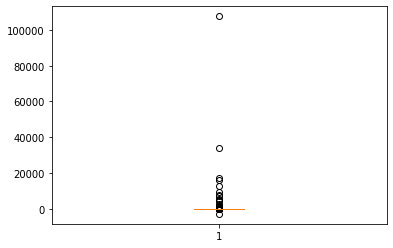

In [146]:
# there are big outliers
plt.boxplot(x);

###  Voting members as a percentage of revenue

In [326]:
# identify columns with vote in them
for c in df.columns:
    if 'vot' in c:
        print(c)       

voting_memb_ct
voting_indepmemb_ct


In [327]:
# identify columns with revenue
for c in df.columns:
    if 'rev_tot' in c:
        print(c)       

rev_tot_prioryr
rev_tot_curyr


In [331]:
df_vote = df.copy()

In [332]:
df_vote['vot_mem_div_rev'] = df_vote.voting_memb_ct / df_vote.rev_tot_curyr

In [338]:
# remove 0 values

df_vote.drop(df_vote[df_vote.voting_memb_ct == 0].index, inplace=True)

In [340]:
# remove inf values

df_vote.drop(df_vote[df_vote['vot_mem_div_rev'] == np.inf].index, inplace=True)

In [346]:
df_vote.voting_memb_ct.value_counts().head()

5    20514
7    20089
9    18792
6    15562
8    14447
Name: voting_memb_ct, dtype: int64

In [344]:
df_vote['vot_mem_div_rev'].value_counts(dropna=False).shape

(228224,)

In [337]:
df_vote['vot_mem_div_rev'].min()

-0.7019543973941368

In [336]:
df_vote['vot_mem_div_rev'].max()

17.5

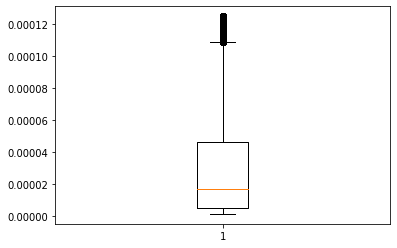

In [367]:
plt.boxplot(winsorize(df_vote['vot_mem_div_rev'],(.1, .1)));

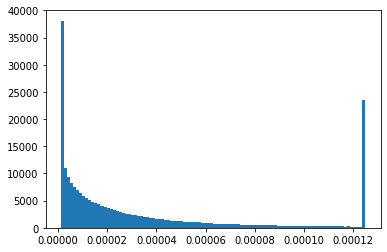

In [353]:
plt.hist(winsorize(df_vote['vot_mem_div_rev'],  (.1,.1)), bins=100);
# plt.hist(winsorize(df_con['con_ct_div_emp_ct'], (0,.1)), bins=100);

### Distribution of 501(c) orgs

#### exempt_status.501c_txt

In [8]:
# identify columns
for c in df.columns:
    if '501' in c:
        print(c)       

exempt_status.501c3
exempt_status.501c_any
exempt_status.501c_txt


In [11]:
# find count of 501(c)(3)
# I'm going to need to convert NaNs to False
df['exempt_status.501c3'].value_counts(dropna=False)

True    179831
NaN      57617
Name: exempt_status.501c3, dtype: int64

In [14]:
# what percent of the total do the 501(c)(3)s make up?

df['exempt_status.501c3'].value_counts(dropna=False)[0] / \
df['exempt_status.501c3'].value_counts(dropna=False).sum()

0.7573489774603281

In [17]:
# what other 501c types are there?
df['exempt_status.501c_txt'].value_counts()

6.0     16719
4.0      8594
5.0      7296
7.0      6795
9.0      3925
8.0      2699
19.0     2688
12.0     2375
14.0     1955
2.0      1644
13.0     1398
10.0      851
25.0      378
15.0       91
17.0       40
29.0       14
26.0        8
11.0        7
16.0        7
27.0        3
18.0        3
23.0        2
20.0        1
Name: exempt_status.501c_txt, dtype: int64

In [ ]:
# for orgs with contractors over 100K
# how are they distributed by org type?



In [23]:
df[~df['contractor_100k_ct'].isnull()].shape


(146216, 110)

In [22]:
# identify columns
for c in df.columns:
    if '100' in c:
        print(c)       

contractor_100k_ct


In [25]:
# how many of the orgs with contractors over 100K are 501c3s
df[~df.name_contractor_1.isnull()].loc[:, 'exempt_status.501c3'].sum()

23103

#### org_form.other_form_desc

In [29]:
# how many different categories are there in org_form.other_form_desc?
# lots of messiness here, for instance non-profit with and without the dash
# unsure how I can use these values

df[~df['org_form.other_form_desc'].isnull()].loc[:,'org_form.other_form_desc'].str.upper().value_counts(dropna=False).head(30)

LABOR UNION                   320
CREDIT UNION                  289
FOUNDATION                    223
UNION                         149
NON-PROFIT                    148
LLC                           132
NON PROFIT                    128
COOPERATIVE                    88
LABOR ORGANIZATION             84
FRATERNITY                     65
SCHOOL                         62
SEE SCHED O                    57
FRATERNAL                      52
CHURCH                         52
501(C)(3)                      48
NONPROFIT                      46
CLUB                           44
LOCAL UNION                    44
UNINCORPORATED ASSOCIATION     43
501C3                          42
CU                             39
SCH O                          35
EXEMPT                         34
ORGANIZATION                   30
NOT FOR PROFIT                 29
EXEMPT ORGANIZATION            27
PUBLIC CHARITY                 25
HOMEOWNERS ASSOCIATION         24
LABOR ORG.                     23
LABOR         

In [26]:
# how many different categories are there in org_form.other_form_desc?
# lots of messiness here, for instance non-profit with and without the dash

df[df['org_form.other_form_desc'].isnull()].shape

# .loc[:,'org_form.other_form_desc'].str.upper().value_counts().head(30)

(233299, 110)

### Identify orgs with at least one contractor
write this to CSV, and use to be able to identify categories of orgs in *990_mission_statement* notebook

In [36]:
# find ein numbers for orgs with contractors and 
# write to a CSV file
df[~df.name_contractor_1.isnull()].loc[:,'ein'].to_csv('ein_orgs_with_contractors.csv', 
                                                       header=True,
                                                       index=False)

#### Count of Vendors for each non-profit

In [41]:
# how many vendors are included?
df[~df.name_contractor_1.isnull()].shape

(30589, 110)

In [42]:
# how many vendors are included?
df[~df.name_contractor_2.isnull()].shape

(19182, 110)

In [43]:
# how many vendors are included?
df[~df.name_contractor_3.isnull()].shape

(14678, 110)

In [44]:
# how many vendors are included?
df[~df.name_contractor_4.isnull()].shape

(11827, 110)

In [45]:
# how many vendors are included?
df[~df.name_contractor_5.isnull()].shape

(9923, 110)

In [14]:
# why are some vendors listed more than once?
df[~df.name_contractor_1.isnull()].loc[:,'name_contractor_1':'name_contractor_2'].head()

,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2
13,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP
17,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING
27,David H Simonds Esq,15 Columbia St Suite 303,Bangor,ME,04401,NaN,Legal Assistance to Members,189920.0,Cloutier Conley & Duffett PA
37,INSIGHT HEALTH CORP,NaN,NaN,NaN,NaN,NaN,MEDICAL STAFFING,455436.0,SODEXO CLINICAL TECHNOLOGY
45,JOHN BOSWELL,5 CLEARVIEW DRIVE,GORHAM,ME,04038,NaN,GOLF PRO,130028.0,NaN


In [61]:
# identical vendors multiple times?
# it appears these contractors are providing different
# types of services to the org

df[(df.name_contractor_1 == df.name_contractor_2) &
  (df.name_contractor_2 == df.name_contractor_3)].head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string
75739,273428380,CICLAVIA INC,2015-07-01,2016-06-30,2016,NaN,+1 (213) 365-0605,CICLAVIA.ORG,525 S HEWITT STREET,LOS ANGELES,CA,NaN,90013,True,NaN,NaN,NaN,NaN,2010.0,NaN,CA,no,NaN,True,NaN,NaN,1477406,NaN,15,15,8,1185.0,0,0.0,1640977.0,0.0,22415.0,0.0,1663392.0,0.0,0.0,83217.0,87000.0,156216,1535261.0,1705478.0,-42086.0,1276603.0,197316.0,1079287.0,1401912,0,154,12568,1414634,0,0,429403,39000,1469728,1938131,-523497,757390,201600,555790,COMMUNITY ARTS RESOURCES,3780 WILSHIRE BOULEVARD SUITE 1020,LOS ANGELES,CA,90010,NaN,EVENT PRE-PRODUCTION,409250.0,COMMUNITY ARTS RESOURCES,3780 WILSHIRE BOULEVARD SUITE 1020,LOS ANGELES,CA,90010,NaN,ADMINISTRATIVE SERVICES,62881.0,COMMUNITY ARTS RESOURCES,3780 WILSHIRE BOULEVARD SUITE 1020,LOS ANGELES,CA,90010,NaN,DEVELOPMENT SERVICES,60893.0,COMMUNITY ARTS RESOURCES,3780 WILSHIRE BOULEVARD SUITE 1020,LOS ANGELES,CA,90010,NaN,EVENT ON-SITE PRODUCTION,56187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,273428380_201606,2015v3.0,201731329349307188,ODY4MjY3ODgwMDc1OTczNzEw
179550,630334002,SOUTHEASTERN IRON WORKERS WELFARE PLAN,2015-02-01,2016-01-31,2016,NaN,+1 (615) 859-0131,NaN,PO BOX 1449,GOODLETTSVILLE,TN,NaN,37370,NaN,True,NaN,NaN,NaN,1953.0,NaN,TN,no,NaN,NaN,True,9.0,37965541,NaN,16,0,0,0.0,0,0.0,0.0,20145528.0,857228.0,0.0,21002756.0,0.0,19937228.0,0.0,0.0,0,1807500.0,21744728.0,-741972.0,15255799.0,78073.0,15177726.0,0,25538091,309120,0,25847211,0,19161438,0,0,1897297,21058735,4788476,19440301,88041,19352260,CONNECTICUT GENERAL LIFE INSURANCE COMPA,3500 PIEDMONT ROAD STE 200,ATLANTA,GA,30305,NaN,STOP LOSS COVERAGE,895588.0,CONNECTICUT GENERAL LIFE INSURANCE COMPA,3500 PIEDMONT ROAD STE 200,ATLANTA,GA,30305,NaN,CLAIMS ADMINISTRATION,809444.0,CONNECTICUT GENERAL LIFE INSURANCE COMPA,3500 PIEDMONT ROAD STE 200,ATLANTA,GA,30305,NaN,PPO ACCESS,220540.0,GEMGROUP,1200 THREE GATEWAY CENTER,PITTSBURGH,PA,15222,NaN,PLAN ADMINISTRATION,213483.0,SOUTHERN BENEFIT,2001 CALDWELL DR

#### Join Mission of Non-Profit Orgs - this was running very slowly, by refining the mission statements into fewer categories, I'm hoping to improve this

In [90]:
df.dtypes.head()

ein                int64
name_org          object
tax_date_begin    object
tax_date_end      object
tax_yr             int64
dtype: object

In [93]:
# join EIN numbers and pullin
# the organization’s mission or most significant activities:

df.set_index('ein').join(org_mission.set_index('ein_org'), how='left')


KeyboardInterrupt



In [91]:
# join EIN numbers and pullin
# the organization’s mission or most significant activities:

df.merge(org_mission, 
         how='left',
         left_on='ein',
         right_on='ein_org')

KeyboardInterrupt: 